In [279]:
import numpy as np
import seaborn as sns
import sympy as sp
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.style.use('default') # 使用默认样式
from tools_2D import *
from shape_fns import *
from Elements import *
from Mesh import create_mesh, Boundary
import pickle
from scipy.interpolate import griddata

with open("Data/data.pkl", "rb") as f:
    data_ori = pickle.load(f)
path = 'Data'

# Q5

In [397]:

def draw_exact(elements_list, dir ='x'):
    # Initialize global_min and global_max
    global_min = float('inf')
    global_max = float('-inf')

    a_b =elements_list[0].a_b
    # Loop over each element in the elements_list
    for test_element in elements_list:
        
        # Evaluate the exact_fn at each mapping point of the test_element
        values = []
        test_inputs = test_element.sample_points(refine)
        for xy in test_element.mapping(test_inputs):
            value = output(exact_fn(xy[0], xy[1], a_b), dir)
            values.append(value)
        
        # Find the minimum and maximum value for the current element
        local_min = np.min(values)
        local_max = np.max(values)
        
        # Update global_min and global_max
        if local_min < global_min:
            global_min = local_min
        if local_max > global_max:
            global_max = local_max

    if type == 'stress':
        print('Direction:', dir)
        print('Maximum stress value:', global_max)
        print('SCF in model:', global_max/50)
        print('SCF in theory:', 1+2*1/a_b)

    for i in range(len(elements_list)):
        test_element = elements_list[i]
        test_inputs = test_element.sample_points(refine)
        test_mapping = test_element.mapping(test_inputs)
        test_output = [output(exact_fn(xy[0], xy[1], a_b), dir) for xy in test_mapping]
        test_x, test_y, test_z = grid_to_mat(test_mapping, test_output)
        # plt.scatter(test_mapping[:, 0], test_mapping[:, 1], s=1, c=test_output)
        plt.imshow(test_z, extent=(test_mapping[:, 0].min(),
                                            test_mapping[:, 0].max(),
                                            test_mapping[:, 1].min(),
                                            test_mapping[:, 1].max()),
                                            origin='lower', aspect='auto',
                                            interpolation='bilinear',cmap='jet',
                                            vmin=global_min, vmax=global_max)
        # 绘制元素的边界
        vertices = test_element.vertices
        vertices = np.vstack([vertices, vertices[0]])  # 将第一个顶点再次添加到数组的末尾，以便封闭形状
        vertices_x, vertices_y = zip(*vertices)  # 解压顶点坐标
        plt.plot(vertices_x, vertices_y,  color='white', linewidth=0.7)  # 使用黑色线绘制边界，并使用小圆点表示顶点s
    plt.xlim(0, 40)
    plt.ylim(0, 40)
    # Display the color bar
    plt.colorbar()
    dir_str = "{ %s }" % dir
    plt.title(rf"Exact solution: $\sigma_{dir_str} \; Mpa$")
    plt.show()

In [430]:
def draw_Q5(elements_list, dir='xy', type='disp', show = False):
    
    fig = plt.figure(figsize=(6, 7))
    
    # 使用 gridspec 定义子图的布局
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 4])  # 第一个数字是 ax1 的高度，第二个数字是 ax2 的高度
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    ax2.set_aspect('equal')

    # 获取 ax1 的当前位置
    pos1 = ax1.get_position()

    # 调整 ax1 的宽度和位置
    reduced_width = 0.62  # 减小 ax1 的宽度到 0.5
    ax1.set_position([0.124, pos1.y0, reduced_width, pos1.height])
    ax2.set_position([0.1, 0.1, 0.8, 0.5])  # slight adjustment to avoid overlap

    # # 在子图上绘制一些示例数据
    # ax1.plot([0, 1, 2], [0, 1, 0])
    # ax2.plot([0, 1, 2], [0, 1, 2])


    global_min = min([np.min([output(test_element(xy[0], xy[1], type), dir) for xy in test_element.sample_points(refine)]) for test_element in elements_list])
    global_max = max([np.max([output(test_element(xy[0], xy[1], type), dir) for xy in test_element.sample_points(refine)]) for test_element in elements_list])
    max_values_coords = []
    min_values_coords = []

    a_b =elements_list[0].a_b
    # 获取每个元素的最大值/最小值和对应的坐标
    for test_element in elements_list:
        outputs = [output(test_element(xy[0], xy[1], type), dir) for xy in test_element.sample_points(refine)]
        
        # 对于最大值
        max_value_element = max(outputs)
        max_coord_element = test_element.mapping(test_element.sample_points(refine))[np.argmax(outputs)]
        max_values_coords.append((max_value_element, max_coord_element))
        
        # 对于最小值
        min_value_element = min(outputs)
        min_coord_element = test_element.mapping(test_element.sample_points(refine))[np.argmin(outputs)]
        min_values_coords.append((min_value_element, min_coord_element))

    # 计算 global_max 和 global_min 以及获取对应的坐标
    global_max, global_max_coord = max(max_values_coords, key=lambda x: x[0])
    global_min, global_min_coord = min(min_values_coords, key=lambda x: x[0])
    if type == 'stress':
        print('Direction:', dir)
        print('Maximum stress value:', global_max[0])
        print('SCF in model:', global_max[0]/50)
        print('SCF in theory:', 1+2*1/a_b) 

    free_edge = []

    for test_element in elements_list:
        count = 0
        for node in test_element.nodes:
            if abs(node.xy[1]-40) <1e-3:
                count += 1
        if count>1:
            free_edge.append(test_element)
                
        test_inputs = test_element.sample_points(refine)
        test_mapping = test_element.mapping(test_inputs)
        test_output = [output(test_element(xy[0], xy[1], type), dir)
                        for xy in test_inputs]
        test_x, test_y, test_z = grid_to_mat(test_mapping, test_output)

        ax2.imshow(test_z, extent=(test_mapping[:, 0].min(),
                                    test_mapping[:, 0].max(),
                                    test_mapping[:, 1].min(),
                                    test_mapping[:, 1].max()),
                    origin='lower', aspect='auto',
                    interpolation='none', cmap='jet',
                    vmin=global_min, vmax=global_max)
       
        # 绘制元素的边界
        vertices = test_element.vertices
        vertices = np.vstack([vertices, vertices[0]])
        vertices_x, vertices_y = zip(*vertices)
        ax2.plot(vertices_x, vertices_y,  color='white', linewidth=0.7)

    ax2.set_xlim(0, 40)
    ax2.set_ylim(0, 40)
    fig.colorbar(ax2.get_images()[0], ax=ax2, orientation='vertical')
    ax2.scatter(global_max_coord[0], global_max_coord[1],s=50, color='blue')
    ax2.text(global_max_coord[0], global_max_coord[1]-4, f"{global_max[0]:.2f}", color='white', fontsize=13, verticalalignment='bottom',
         bbox=dict(facecolor='black', alpha=0.6, edgecolor='none', boxstyle="round,pad=0.3"))

    if type == 'disp':
        type_str = 'U'
        unit = 'mm'
    elif type == 'strain':
        type_str = '\\epsilon'
        unit = ''
    elif type == 'stress':
        type_str = '\\sigma'
        unit = 'Mpa'
    dir_str = "{ %s }" % dir
    ax2.set_title(rf"${type_str}_{dir_str}\; {unit}$")
    
    # Plot for free edge
    print('number of elements at free edge:', len(free_edge))
    # Dictionary to store the accumulated stress and count for each node
    node_stress_accumulator = {}
    
    for elem in free_edge:
        points, Ws = Gauss_points(elem, 2)
        for i in range(len(elem.nodes)):
            node = elem.nodes[i]
            if abs(node.xy[1] - 40) < 1e-3:
                node_value = 0
                for j in range(len(points)):
                    point = points[j]
                    stress = output(elem(point[0], point[1], type), dir)
                    node_value += elem.phis[j](point[0], point[1]) * stress
                
                # Add the extrapolated value to the accumulator
                if node.xy[0] in node_stress_accumulator:
                    node_stress_accumulator[node.xy[0]][0] += node_value
                    node_stress_accumulator[node.xy[0]][1] += 1
                else:
                    node_stress_accumulator[node.xy[0]] = [node_value, 1]

    # Sort nodes based on x-coordinates
    sorted_nodes = sorted(node_stress_accumulator.keys())

    # Compute the average stress for each node and store in x_data and y_data
    x_data = []
    y_data = []
    for x_coord in sorted_nodes:
        total_stress, count = node_stress_accumulator[x_coord]
        x_data.append(x_coord)
        y_data.append(total_stress / count)
    ax1.scatter(x_data,y_data, )
    ax1.set_title(rf"${type_str}_{dir_str}$ on the Free Edge")

    # plt.tight_layout()
    plt.savefig('images/Q5_{}_{}_{}.png'.format(a_b, dir, test_element.shape))
    if show: 
        plt.show()

# Run the function with sample data
# draw(elements_list, dir='xy', type='disp')  # Uncomment this line to run the function with your actual data


In [431]:
dirs = ['x', 'y', 'xy', 'von']
indexs = len(data_ori)

In [ ]:
dir ='xy'
type = 'stress'
if type == 'disp':
    type_str = 'U'
elif type == 'strain':
    type_str = '\\epsilon'
elif type == 'stress':
    type_str = '\\sigma'
dir_str = "{ %s }" % dir
iii = -1
refine = 3

for dir in dirs:
    for iii in range(indexs):
        elements_list = data_ori[iii]['elements_list']
        mesh_size = data_ori[iii]['mesh_size']
        mesh_shape = data_ori[iii]['mesh_shape']
        if mesh_size != 2:
            print("mesh_size should be 2, not {}".format(mesh_size))
            pass
            # raise ValueError ("mesh_size should be 2")
        else:
            a_b =data_ori[iii]['a_b'] 
            data_keys = list(data_ori[iii].keys())[:3]
            for key in data_keys:
                print(key, data_ori[iii][key])

            # draw(elements_list, dir, type)
            # draw(elements_list, 'y', type)
            draw_Q5(elements_list, dir, type)


Direction: von
Maximum stress value: 2050.0
SCF in model: 41.0
SCF in theory: 41.0


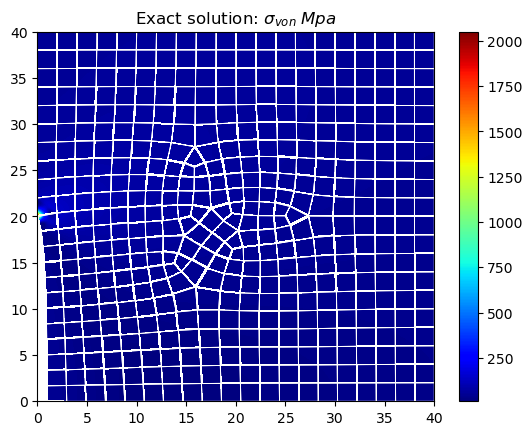

In [433]:
draw_exact(elements_list,dir)
